# DeepGlobe Land Cover Segmentation  
## 01 – Data Preparation & Exploration

This notebook performs **initial data preparation and exploration** for the  **DeepGlobe Land Cover Classification Dataset**.

### Objectives
- Verify dataset structure
- Load satellite images and segmentation masks
- Inspect image–mask alignment
- Understand class distribution
- Perform basic sanity checks before model training

No deep learning models are trained in this notebook.

In [2]:
# Download the dataset from kaggle
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download(
    "balraj98/deepglobe-land-cover-classification-dataset"
)

print("Dataset downloaded to:")
print(path)

# List files to confirm
for root, dirs, files in os.walk(path):
    print(root)
    break

100%|██████████| 2.74G/2.74G [03:19<00:00, 14.8MB/s]

Extracting files...


Dataset downloaded to:
C:\Users\ibaan\.cache\kagglehub\datasets\balraj98\deepglobe-land-cover-classification-dataset\versions\2
C:\Users\ibaan\.cache\kagglehub\datasets\balraj98\deepglobe-land-cover-classification-dataset\versions\2


## Section 1 - Imports and Global Configuration

In [4]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Dataset paths

In [5]:
PROJECT_ROOT = Path("..")

RAW_DATA = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"

TRAIN_DIR = RAW_DATA / "train"
VALID_DIR = RAW_DATA / "valid"

CLASS_DICT_PATH = RAW_DATA / "class_dict.csv"
METADATA_PATH = RAW_DATA / "metadata.csv"

PROCESSED_TRAIN = PROCESSED_DATA / "train"
PROCESSED_VALID = PROCESSED_DATA / "valid"

PROCESSED_TRAIN.mkdir(parents=True, exist_ok=True)
PROCESSED_VALID.mkdir(parents=True, exist_ok=True)

print(f"Raw data directory: {RAW_DATA}")
print(f"Processed data directory: {PROCESSED_DATA}")

Raw data directory: ..\data\raw
Processed data directory: ..\data\processed


## Section 2 - Load Dataset Metadata

In [6]:
class_dict = pd.read_csv(CLASS_DICT_PATH)
metadata = pd.read_csv(METADATA_PATH)

display(class_dict)
display(metadata.head())

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png


## Section 3 - Land Cover Classes

The dataset defines 7 semantic classes. Each class is encoded as an RGB color in the mask images and must be converted into a class index.

In [7]:
CLASS_MAPPING = {
    (0, 255, 255): 0,    # Urban
    (255, 255, 0): 1,    # Agriculture
    (255, 0, 255): 2,    # Rangeland
    (0, 255, 0): 3,      # Forest
    (0, 0, 255): 4,      # Water
    (255, 255, 255): 5,  # Barren
    (0, 0, 0): 6         # Unknown
}

NUM_CLASSES = len(CLASS_MAPPING)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 7


## Section 4 - Mask Preprocessing

Mask images may contain values other than 0 and 255 due to encoding.
We threshold values at 128 before converting RGB values to class indices.

In [8]:
def threshold_mask(mask: np.ndarray, threshold: int = 128) -> np.ndarray:
    return np.where(mask >= threshold, 255, 0).astype(np.uint8)


def rgb_mask_to_class(mask_rgb: np.ndarray) -> np.ndarray:
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)

    for rgb, class_id in CLASS_MAPPING.items():
        matches = np.all(mask_rgb == np.array(rgb), axis=-1)
        class_mask[matches] = class_id

    return class_mask

## Section 5 - Process a Single Image–Mask Pair

In [9]:
def process_sample(image_path: Path, mask_path: Path):
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("RGB")

    image_np = np.array(image)
    mask_np = threshold_mask(np.array(mask))

    class_mask = rgb_mask_to_class(mask_np)
    return image_np, class_mask

## Visual Sanity Check

We inspect one image–mask pair to verify correct alignment and labeling.

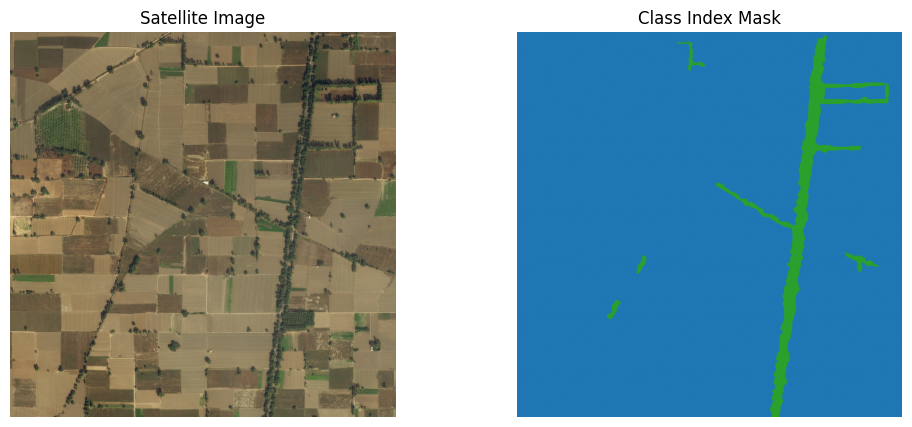

In [11]:
sample_image = sorted(TRAIN_DIR.glob("*_sat.jpg"))[0]
sample_id = sample_image.stem.replace("_sat", "")

img_path = TRAIN_DIR / f"{sample_id}_sat.jpg"
mask_path = TRAIN_DIR / f"{sample_id}_mask.png"

image_np, class_mask = process_sample(img_path, mask_path)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(class_mask, cmap="tab10")
plt.title("Class Index Mask")
plt.axis("off")

plt.show()

## Section 6 - Process Dataset Splits

We apply the preprocessing pipeline to the full training and validationsets and save the results as NumPy arrays.

In [12]:
def process_split(split_dir: Path, output_dir: Path, split_name: str):
    (output_dir / "images").mkdir(parents=True, exist_ok=True)
    (output_dir / "masks").mkdir(parents=True, exist_ok=True)

    image_files = sorted(split_dir.glob("*_sat.jpg"))
    print(f"{split_name}: {len(image_files)} samples")

    for img_path in image_files:
        sample_id = img_path.stem.replace("_sat", "")
        mask_path = split_dir / f"{sample_id}_mask.png"

        if not mask_path.exists():
            continue

        image_np, class_mask = process_sample(img_path, mask_path)

        np.save(output_dir / "images" / f"{sample_id}.npy", image_np)
        np.save(output_dir / "masks" / f"{sample_id}.npy", class_mask)

## Run Data Preparation

In [13]:
process_split(TRAIN_DIR, PROCESSED_TRAIN, "Train")
process_split(VALID_DIR, PROCESSED_VALID, "Validation")

print("Data preparation completed successfully.")

Train: 803 samples
Validation: 171 samples
Data preparation completed successfully.


## Section 7 - Verification

In [14]:
from pathlib import Path

base = Path("../data/processed")
print(list((base / "train" / "images").iterdir())[:3])
print(list((base / "train" / "masks").iterdir())[:3])

[WindowsPath('../data/processed/train/images/100694.npy'), WindowsPath('../data/processed/train/images/102122.npy'), WindowsPath('../data/processed/train/images/10233.npy')]
[WindowsPath('../data/processed/train/masks/100694.npy'), WindowsPath('../data/processed/train/masks/102122.npy'), WindowsPath('../data/processed/train/masks/10233.npy')]


In [15]:
train_imgs = len(list((base / "train" / "images").glob("*.npy")))
train_masks = len(list((base / "train" / "masks").glob("*.npy")))

valid_imgs = len(list((base / "valid" / "images").glob("*.npy")))
valid_masks = len(list((base / "valid" / "masks").glob("*.npy")))

print(train_imgs, train_masks)
print(valid_imgs, valid_masks)

803 803
0 0


In [16]:
import numpy as np

sample_img = np.load((base / "train" / "images").glob("*.npy").__iter__().__next__())
sample_mask = np.load((base / "train" / "masks").glob("*.npy").__iter__().__next__())

print("Image shape:", sample_img.shape)
print("Mask shape :", sample_mask.shape)
print("Image dtype:", sample_img.dtype)
print("Mask dtype :", sample_mask.dtype)

Image shape: (2448, 2448, 3)
Mask shape : (2448, 2448)
Image dtype: uint8
Mask dtype : uint8
